# Comparing Models

- Run the models 3 times with different random sees (24, 45, 93) at T/T-split to get 3 different R2-scores
- Take the STD of the 3 R2-scores and make error bars for the different models.

T/T-split with random seed was done in notebook 12, so get the first metrics from there.
This notebook will provide metrics for random seed 2 and 3. 

I have tried to clean the code a little bit to be able to make it run faster.
There are less explenation in this notebook than in notebok nr 12. That is bc I do the same thing 2 more times. To get more explenations to things please look at notevook 12.

## Import stuff

In [47]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline

## Load data

In [48]:
data = pd.read_csv('./data_top10c_more_lyrics.csv')
data.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,Country,Region,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,gb,eu,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.879
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756
2,2,78,49766,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-24,2017,12,24,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756


## Fix a little bit with the data

#### Get dummies for the Country column + include in the data frame

In [49]:
country_dum = pd.get_dummies(data['Country'])

data_c = pd.concat([data, country_dum], axis=1)

data_c.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,...,Tempo,Valence,au,ca,de,fr,gb,it,nl,us
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,...,172.656,0.879,0,0,0,0,1,0,0,0
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,...,105.003,0.756,0,0,0,0,0,1,0,0
2,2,78,49766,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-24,2017,12,24,...,105.003,0.756,0,0,0,0,0,1,0,0


#### Get dummies for the Position column  + include in the data frame

In [50]:
position_dum = pd.get_dummies(data['Position'])

data_c_p = pd.concat([data_c, position_dum], axis=1)

data_c_p.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,...,191,192,193,194,195,196,197,198,199,200
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,...,0,0,0,0,0,0,0,0,0,0
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,...,0,0,0,0,0,0,0,0,0,0
2,2,78,49766,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-24,2017,12,24,...,0,0,0,0,0,0,0,0,0,0


#### Group by ID, sum()

In [51]:
data_cp_groupbyID = data_c_p.groupby('ID').sum()
data_cp_groupbyID.head(3)

,Unnamed: 0,Position,Streams,Year,Month,Day,Acousticness,Energy,Instrumentalness,Mode,...,191,192,193,194,195,196,197,198,199,200
ID,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,485336363,85033,62948380,1716467,4972,13379,111.48100,533.577,0.000000,851.0,...,5.0,5.0,3.0,2.0,2.0,8.0,0.0,5.0,3.0,3.0
007d7JT41sSc1HqWTs4uw7,624441,563,233403,6051,8,30,0.00912,2.286,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
00BuKLSAFkaEkaVAgIMbeA,310234,121,209865,2017,2,6,0.00587,0.832,0.000789,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Make 2 new columns for average Streams and average Position

In [52]:
data_cp_groupbyID['avg_Streams'] = data_cp_groupbyID['Streams']/len(data_cp_groupbyID)

data_cp_groupbyID['avg_Position'] = data_cp_groupbyID['Position']/len(data_cp_groupbyID)

data_cp_groupbyID.head(3)

,Unnamed: 0,Position,Streams,Year,Month,Day,Acousticness,Energy,Instrumentalness,Mode,...,193,194,195,196,197,198,199,200,avg_Streams,avg_Position
ID,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,485336363,85033,62948380,1716467,4972,13379,111.48100,533.577,0.000000,851.0,...,3.0,2.0,2.0,8.0,0.0,5.0,3.0,3.0,7655.159917,10.340873
007d7JT41sSc1HqWTs4uw7,624441,563,233403,6051,8,30,0.00912,2.286,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.384166,0.068466
00BuKLSAFkaEkaVAgIMbeA,310234,121,209865,2017,2,6,0.00587,0.832,0.000789,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.521707,0.014715


#### Drop columns that make no sense after the group by or that I do not need

In [53]:
data_cps = data_cp_groupbyID.drop(['Unnamed: 0', 'Position', 'Streams', 'Year', 'Month', 'Day', 'Acousticness',
                        'Energy', 'Instrumentalness', 'Mode', 'Tempo', 'Valence'], axis=1)
data_cps.head(3)

,au,ca,de,fr,gb,it,nl,us,1,2,...,193,194,195,196,197,198,199,200,avg_Streams,avg_Position
ID,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0,0.0,0.0,...,3.0,2.0,2.0,8.0,0.0,5.0,3.0,3.0,7655.159917,10.340873
007d7JT41sSc1HqWTs4uw7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.384166,0.068466
00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.521707,0.014715


In [54]:
# make a new column for ID so that I can merge on ID later
data_cps['ID'] = data_cps.index
data_cps.head(3)

,au,ca,de,fr,gb,it,nl,us,1,2,...,194,195,196,197,198,199,200,avg_Streams,avg_Position,ID
ID,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0,0.0,0.0,...,2.0,2.0,8.0,0.0,5.0,3.0,3.0,7655.159917,10.340873,000xQL6tZNLJzIrtIgxqSl
007d7JT41sSc1HqWTs4uw7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.384166,0.068466,007d7JT41sSc1HqWTs4uw7
00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.521707,0.014715,00BuKLSAFkaEkaVAgIMbeA


#### Drop rows that are duplicates and keep only one row for each song (based on ID)

In [55]:
data_per_song = data.drop_duplicates(subset=['ID'], keep='first')
data_per_song.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,Country,Region,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,gb,eu,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.8790
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.7560
43,43,147,43037,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,2017-12-24,2017,12,24,fr,eu,NaN,0.9140,0.227,0.16300,1.0,81.887,0.0498


#### Drop all columns that might change per song

In [56]:
data_per_song = data_per_song.drop(['Unnamed: 0', 'Position', 'Streams', 'Date', 'Year', 'Month', 'Day', 'Country',
                                   'Region'], axis=1)
data_per_song.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.8790
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.7560
43,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,NaN,0.9140,0.227,0.16300,1.0,81.887,0.0498


#### Combine the 2 data frames with columns that may and may not change per song

In [57]:
big_df_song = data_per_song.merge(data_cps, how='inner', on='ID')
big_df_song.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,193,194,195,196,197,198,199,200,avg_Streams,avg_Position
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.8790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.910738,0.021525
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.7560,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,483.813207,0.627873
2,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,NaN,0.9140,0.227,0.16300,1.0,81.887,0.0498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.233735,0.017877


#### Drop rows that have missing values in the Lyrics column <BR />
We can use dropna to drop all rows that has missing values (should mostly be the Lyrics column)

In [58]:
len(big_df_song)

8223

In [59]:
big_df_song = big_df_song.dropna(axis=0, how='any')

In [60]:
len(big_df_song)

4995

### TextBlob

#### Turn the lyrics in the Lyrics column into string

In [61]:
big_df_song['Lyrics'] = big_df_song['Lyrics'].astype(str)

#### Make and run function for TextBlob on the Lyrics

In [62]:
def sentiment_func(lyrics):
    try:
        return TextBlob(lyrics).sentiment
    except:
        return None

In [63]:
big_df_song['pol_sub'] = big_df_song['Lyrics'].apply(sentiment_func)

#### Split the pol_sub column into 2 new columns (Polarity, Subjectivity)

In [64]:
big_df_song['Polarity'] = big_df_song['pol_sub'].apply(lambda x: x[0])
big_df_song['Subjectivity'] = big_df_song['pol_sub'].apply(lambda x: x[1])

#### Drop the pol_sub column

In [65]:
big_df_song = big_df_song.drop(['pol_sub'], axis=1)

### Do a quick check of the entire data frame

In [66]:
big_df_song.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,195,196,197,198,199,200,avg_Streams,avg_Position,Polarity,Subjectivity
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.879,...,0.0,0.0,0.0,0.0,0.0,0.0,4.910738,0.021525,-0.044455,0.590802
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756,...,0.0,0.0,1.0,0.0,0.0,0.0,483.813207,0.627873,0.583150,0.670696
5,Somme,13 Block,2xkxBVJHf9jQsq7g46UtQx,"J'ai fait l'aller, j'suis sur le retour\nLa ma...",0.4940,0.678,0.00151,0.0,79.979,0.528,...,0.0,1.0,0.0,0.0,0.0,0.0,4.951356,0.046820,0.173810,0.541667


In [67]:
big_df_song.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4995 entries, 0 to 8222
Columns: 222 entries, Track Name to Subjectivity
dtypes: float64(218), object(4)
memory usage: 8.5+ MB


#####################################################################################################################

# Random_state = 45

## Train/test split

Divide the data into a train and a test set (with default size: train/test split size -> 0.75/0.25)

In [109]:
big_dep   = big_df_song['Valence']
big_indep = big_df_song

# change the random_state to 45
indep_train, indep_test, dep_train, dep_test = train_test_split(big_indep, big_dep, random_state=45)

indep_train.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,195,196,197,198,199,200,avg_Streams,avg_Position,Polarity,Subjectivity
4044,U Aint Never,Kodak Black,6scsBF1tws6Dg8VL3Xu5bS,"boy you ain't never sell no work, aye sniper g...",0.112,0.556,0.000000,0.0,140.039,0.422,...,0.0,0.0,0.0,0.0,0.0,0.0,22.650249,0.022741,0.069444,0.505556
7017,Wooh!,Sneazzy,0GM3UqhPhW9qdBBvn4o8ow,Hey !\nSupersound est dans cette... Hey !\n\nL...,0.484,0.571,0.000000,0.0,132.726,0.704,...,0.0,0.0,0.0,0.0,0.0,0.0,2.815517,0.017998,0.055952,0.690476
5574,The Christmas Song (Merry Christmas To You),Nat King Cole,5humEOJehpAwMJEJmb0JJ2,Chestnuts roasting on an open fire\nJack frost...,0.904,0.095,0.000034,1.0,72.760,0.188,...,0.0,0.0,1.0,0.0,0.0,0.0,2113.937857,1.229235,0.240833,0.499881


## NLP

In [110]:
# read in csv with stop words
stop_words_df = pd.read_csv('./stop_words.csv')

# turn the df to list
stop_words = stop_words_df['colummn'].tolist()

### CountVectorizer (use in model 1)

In [111]:
# instantiate the model (stop-words the list of 4 languages and max top features 500)
cvec = CountVectorizer(stop_words = stop_words, max_features = 500)

# fit the count vectorizer with training data. 
cvec.fit(indep_train['Lyrics'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'ar...s', 'trabajais', 'trabajan', 'podria', 'podrias', 'podriamos', 'podrian', 'podriais', 'yo', 'aquel'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

**Train**

In [112]:
# transform X_train
cvec_data = cvec.transform(indep_train['Lyrics'])

# Turn the features into a data frame
df  = pd.DataFrame(cvec_data.todense(),columns=cvec.get_feature_names())

# Concat with big data frame (use for fitting the model)
indep_train_cvec = pd.concat([indep_train.reset_index(drop=True), df], axis=1)

indep_train_cvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,young,ze,zeg,zeit,zie,zieh,zijn,zo,étais,était
0,U Aint Never,Kodak Black,6scsBF1tws6Dg8VL3Xu5bS,"boy you ain't never sell no work, aye sniper g...",0.112,0.556,0.000000,0.0,140.039,0.422,...,0,0,0,0,0,0,0,0,0,0
1,Wooh!,Sneazzy,0GM3UqhPhW9qdBBvn4o8ow,Hey !\nSupersound est dans cette... Hey !\n\nL...,0.484,0.571,0.000000,0.0,132.726,0.704,...,0,0,0,0,0,0,0,0,0,0
2,The Christmas Song (Merry Christmas To You),Nat King Cole,5humEOJehpAwMJEJmb0JJ2,Chestnuts roasting on an open fire\nJack frost...,0.904,0.095,0.000034,1.0,72.760,0.188,...,0,0,0,0,0,0,0,0,0,0


**Test**

In [113]:
# transform X_test
cvec_data2 = cvec.transform(indep_test['Lyrics'])

# Turn the features into a data frame
df2  = pd.DataFrame(cvec_data2.todense(),columns=cvec.get_feature_names())

# Concat with big data frame (use for scoring the model)
indep_test_cvec = pd.concat([indep_test.reset_index(drop=True), df2], axis=1)

indep_test_cvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,young,ze,zeg,zeit,zie,zieh,zijn,zo,étais,était
0,It's Only Christmas,Ronan Keating,2oXy2U15tnQ1HIRrpjLp41,Do you remember what you wished for every Chri...,0.280,0.526,0.000004,1.0,138.080,0.246,...,0,0,0,0,0,0,0,0,0,0
1,Bring It On,Racoon,3r0YcpBfet2onXzmxkGg7A,Sitting on top of his shoulders where no one ...,0.109,0.697,0.000000,1.0,140.033,0.275,...,0,0,0,0,0,0,0,0,0,0
2,In Check,Bryson Tiller,4nBhjVklA3Mtnyzshg4KmD,"yeah, when when i look you in your face i see...",0.939,0.212,0.000002,1.0,116.004,0.416,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF (use in model 2)

In [114]:
# instantiate the model (stop-words the list of 4 languages and max top features 500)
tvec = TfidfVectorizer(stop_words = stop_words, max_features = 500) 

# fit the count vectorizer with training data. 
tvec.fit(indep_train['Lyrics'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'ar...s', 'trabajais', 'trabajan', 'podria', 'podrias', 'podriamos', 'podrian', 'podriais', 'yo', 'aquel'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

**Train**

In [115]:
# transform X_train
tvec_data = tvec.transform(indep_train['Lyrics'])

# Turn the features into a data frame
df3  = pd.DataFrame(tvec_data.todense(),columns=tvec.get_feature_names())

# Concat with big data frame (use for fitting the model)
indep_train_tvec= pd.concat([indep_train.reset_index(drop=True), df3], axis=1)

indep_train_tvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,young,ze,zeg,zeit,zie,zieh,zijn,zo,étais,était
0,U Aint Never,Kodak Black,6scsBF1tws6Dg8VL3Xu5bS,"boy you ain't never sell no work, aye sniper g...",0.112,0.556,0.000000,0.0,140.039,0.422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Wooh!,Sneazzy,0GM3UqhPhW9qdBBvn4o8ow,Hey !\nSupersound est dans cette... Hey !\n\nL...,0.484,0.571,0.000000,0.0,132.726,0.704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Christmas Song (Merry Christmas To You),Nat King Cole,5humEOJehpAwMJEJmb0JJ2,Chestnuts roasting on an open fire\nJack frost...,0.904,0.095,0.000034,1.0,72.760,0.188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Test**

In [116]:
# transform X_test
tvec_data4 = tvec.transform(indep_test['Lyrics'])

# Turn the features into a data frame
df4  = pd.DataFrame(tvec_data4.todense(),columns=tvec.get_feature_names())

# Concat with big data frame (use for scoring the model)
indep_test_tvec = pd.concat([indep_test.reset_index(drop=True), df4], axis=1)

indep_test_tvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,young,ze,zeg,zeit,zie,zieh,zijn,zo,étais,était
0,It's Only Christmas,Ronan Keating,2oXy2U15tnQ1HIRrpjLp41,Do you remember what you wished for every Chri...,0.280,0.526,0.000004,1.0,138.080,0.246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bring It On,Racoon,3r0YcpBfet2onXzmxkGg7A,Sitting on top of his shoulders where no one ...,0.109,0.697,0.000000,1.0,140.033,0.275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,In Check,Bryson Tiller,4nBhjVklA3Mtnyzshg4KmD,"yeah, when when i look you in your face i see...",0.939,0.212,0.000002,1.0,116.004,0.416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Models (LinReg, Lasso, RF, Ada/Gradient Boost) - CountVec

### Linear Regression

In [117]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict and score
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### LinReg #1 - CountVec + all coefs

In [118]:
# define X and y
X_train = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train = dep_train
X_test = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test = dep_test

# chose model 
linreg = LinearRegression()

# call function
evaluate_model(linreg, X_train, X_test, y_train, y_test)

{'MSE': 0.2176512758306596, 'Score (R^2)': 0.018647294642352596}

**Importance of the coefficients**

In [119]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train.columns,linreg.coef_))).abs().sort_values(ascending=False).head(10)

avg_Position    6.396832e+10
au              3.800089e+10
ca              3.647958e+10
us              3.640951e+10
gb              3.579215e+10
it              3.549080e+10
fr              3.412688e+10
de              3.202012e+10
nl              3.047732e+10
1               1.027450e+10
dtype: float64

#### LinReg #2 - CountrVec + top 10 coefs

In [120]:
# define X and y
X_train2 = indep_train_cvec[['avg_Position', 'au', 'it', 'ca', 'us', 'gb', 'fr', 'de', 'nl', 1]]
y_train2 = dep_train
X_test2 = indep_test_cvec[['avg_Position', 'au', 'it', 'ca', 'us', 'gb', 'fr', 'de', 'nl', 1]]
y_test2 = dep_test

# chose model 
linreg2 = LinearRegression()

# call function
evaluate_model(linreg2, X_train2, X_test2, y_train2, y_test2)

{'MSE': 0.2194060625427638, 'Score (R^2)': 0.0027594332154159407}

#### LinReg #3 - CountrVec + top 3 coefs

In [121]:
# define X and y
X_train3 = indep_train_cvec[['avg_Position', 'au', 'it']]
y_train3 = dep_train
X_test3 = indep_test_cvec[['avg_Position', 'au', 'it']]
y_test3 = dep_test

# chose model 
linreg3 = LinearRegression()

# call function
evaluate_model(linreg3, X_train3, X_test3, y_train3, y_test3)

{'MSE': 0.2205568763590877, 'Score (R^2)': -0.007729319613470675}

### Lasso Regressor

In [122]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    
    # Best Hyperparameters
    gs = GridSearchCV(model, grid) # cv default = 3
    
    # fit
    gs.fit(X_train_s, y_train)
     
    return {'best_score': gs.best_score_,'best_params': gs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Lasso #1 - CountVec + all coefs**

In [123]:
# Declare indep and dep
X_train4 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train4 = dep_train
X_test4 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID','Lyrics', 'Valence'], axis=1)
y_test4 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg, grid, X_train4, y_train4)

{'best_params': {'alpha': 0.005336699231206312, 'selection': 'random'},
 'best_score': 0.16935068794705138}

In [124]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.0053, selection='random')

# call function
evaluate_model(lassoreg, X_train4, X_test4, y_train4, y_test4)

{'MSE': 0.19967626464262742, 'Score (R^2)': 0.17404653973931827}

In [125]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train4.columns,lassoreg.coef_))).abs().sort_values(ascending=False).head(15)

Energy          0.083115
baby            0.016887
Acousticness    0.016748
pa              0.005854
shit            0.005817
che             0.005718
niggas          0.005308
girl            0.005271
viel            0.005233
thing           0.004903
oh              0.004701
ogni            0.004582
bang            0.004519
boy             0.004483
je              0.004411
dtype: float64

#### Lasso #2 - CountVec + top 10 coefs

In [126]:
# Declare indep and dep
X_train5 = indep_train_cvec[['Energy', 'baby', 'Acousticness', 'pa', 'shit', 'che', 'niggas', 'girl', 'viel', 'thing']]
y_train5 = dep_train
X_test5 = indep_test_cvec[['Energy', 'baby', 'Acousticness', 'pa', 'shit', 'che', 'niggas', 'girl', 'viel', 'thing']]
y_test5= dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg2 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg2, grid, X_train5, y_train5)

{'best_params': {'alpha': 0.001, 'selection': 'random'},
 'best_score': 0.17486129208903878}

In [127]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg2 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.001, 
                  selection='random')

# call function
evaluate_model(lassoreg2, X_train5, X_test5, y_train5, y_test5)

{'MSE': 0.20141171212616427, 'Score (R^2)': 0.15962691995511147}

#### Lasso #3 - CountVec + top 3 coefs

In [128]:
# Declare indep and dep
X_train6 = indep_train_cvec[['Energy', 'baby', 'Acousticness']]
y_train6 = dep_train
X_test6 = indep_test_cvec[['Energy', 'baby', 'Acousticness']]
y_test6 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg3 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg3, grid, X_train6, y_train6)

{'best_params': {'alpha': 0.001, 'selection': 'cyclic'},
 'best_score': 0.15719158717791926}

In [129]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg3 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.001, 
                  selection='cyclic')

# call function
evaluate_model(lassoreg3, X_train6, X_test6, y_train6, y_test6)

{'MSE': 0.20312701972348704, 'Score (R^2)': 0.14525202070823995}

### Random Forest Regressor

You do not have to scale a Random Forest.

In [130]:
def get_best_hype(model, params, X_train, y_train):  
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=40)
    
    # fit
    rs.fit(X_train, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # fit
    model.fit(X_train, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### Random Forest #1 - CountVec + all coefs

In [131]:
# Declare indep and dep
X_train7 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train7 = dep_train
X_test7 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test7 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr = RandomForestRegressor(random_state=24)

get_best_hype(rfr, params, X_train7, y_train7)

{'best_params': {'bootstrap': True,
  'max_depth': 14,
  'max_features': 'auto',
  'n_estimators': 90,
  'verbose': 0},
 'best_score': 0.21368334564009156}

In [132]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr = RandomForestRegressor(max_depth=14, max_features='auto', n_estimators=90, verbose=0, bootstrap=True, 
                            random_state=24)

# call function
evaluate_model(rfr, X_train7, X_test7, y_train7, y_test7)

{'MSE': 0.19547967373890124, 'Score (R^2)': 0.20839979033017253}

**Feature importance**

In [133]:
pd.Series(dict(zip(X_train7.columns,rfr.feature_importances_))).abs().sort_values(ascending=False).head(15)

Energy              0.224798
Acousticness        0.049650
Instrumentalness    0.027722
Tempo               0.024732
baby                0.022117
Polarity            0.018789
Subjectivity        0.016952
avg_Position        0.016709
avg_Streams         0.012501
oh                  0.008746
hab                 0.006900
je                  0.006241
che                 0.006053
girl                0.005590
don                 0.005441
dtype: float64

#### Random Forest #2 - CountVec + top 10 features

In [134]:
# define X and y
X_train8 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo', 'baby', 'Polarity', 'Subjectivity',
                             'avg_Position','avg_Streams' , 'oh', 'hab']]
y_train8 = dep_train
X_test8 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo', 'baby', 'Polarity', 'Subjectivity',
                             'avg_Position','avg_Streams' , 'oh', 'hab']]
y_test8 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr2 = RandomForestRegressor(random_state=24)

get_best_hype(rfr2, params, X_train8, y_train8)

{'best_params': {'bootstrap': True,
  'max_depth': 11,
  'max_features': 'log2',
  'n_estimators': 90,
  'verbose': 0},
 'best_score': 0.17670230913506144}

In [135]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr2 = RandomForestRegressor(max_depth=11, max_features='log2', n_estimators=90, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr2, X_train8, X_test8, y_train8, y_test8)

{'MSE': 0.19950134325802302, 'Score (R^2)': 0.17549301752127533}

#### Random Forest #3 - CountVec + top 3 features

In [136]:
# define X and y
X_train9 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo']]
y_train9 = dep_train
X_test9 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo']]
y_test9 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr3 = RandomForestRegressor(random_state=24)

get_best_hype(rfr3, params, X_train9, y_train9)

{'best_params': {'bootstrap': True,
  'max_depth': 5,
  'max_features': 'auto',
  'n_estimators': 30,
  'verbose': 0},
 'best_score': 0.1436025595910195}

In [137]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr3 = RandomForestRegressor(max_depth=5, max_features='auto', n_estimators=30, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr3, X_train9, X_test9, y_train9, y_test9)

{'MSE': 0.20434188056302194, 'Score (R^2)': 0.134997303469086}

### Ada and Gradient Boost

In [138]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
     
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=27)
    
    # fit
    rs.fit(X_train_s, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Ada #1 - CountVec + all coefs**

In [139]:
# Declare indep and dep
X_train10 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train10 = dep_train
X_test10 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test10 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('linear', 'square', 'exponential')}

ada = AdaBoostRegressor(random_state=24) 
# base_estimator = DecisionTreeRegressor() (default)
# learning_rate: (default=1.0)

get_best_hype(ada, params, X_train10, y_train10)

{'best_params': {'loss': 'exponential', 'n_estimators': 10},
 'best_score': 0.14528308489176012}

In [140]:
# chose model and use best hyperparameters (from gridsearchCV)
ada = AdaBoostRegressor(n_estimators=10, loss='exponential', random_state=24)
# I'm going with the default base_estimator, bc to choose a rfr is taking too long time

# call function
evaluate_model(ada, X_train10, X_test10, y_train10, y_test10)

{'MSE': 0.20539995917056247, 'Score (R^2)': 0.1260161744267283}

**Gradient #1 - CountVec + all coefs**

In [141]:
# Declare indep and dep
X_train11 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train11 = dep_train
X_test11 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test11 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}


grad = GradientBoostingRegressor(random_state=24) 
# learning_rate: (default=1.0)
# init = BaseEstimator, default = None (loss.init_estimator)

get_best_hype(grad, params, X_train11, y_train11)

{'best_params': {'loss': 'lad',
  'max_depth': 17,
  'max_features': 'auto',
  'n_estimators': 30,
  'verbose': 0},
 'best_score': 0.19625504971011956}

In [142]:
# chose model and use best hyperparameters (from gridsearchCV)
grad = GradientBoostingRegressor(random_state=24, n_estimators=30, loss='lad', max_depth=17 , max_features='auto',
                                 verbose=0)

# call function
evaluate_model(grad, X_train11, X_test11, y_train11, y_test11)

{'MSE': 0.19705145602161905, 'Score (R^2)': 0.19561866237021341}

In [143]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train11.columns,grad.feature_importances_ ))).abs().sort_values(ascending=False).head(15)

Energy              0.054782
Acousticness        0.028384
Tempo               0.026424
Subjectivity        0.018080
Polarity            0.016615
avg_Streams         0.014941
Instrumentalness    0.014744
avg_Position        0.011906
baby                0.010734
know                0.006753
yeah                0.006440
like                0.006064
oh                  0.005841
gb                  0.005111
wanna               0.005027
dtype: float64

**Gradient #2 - CountVec + top 10 coefs**

In [144]:
# define X and y
X_train12 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo', 'Subjectivity', 'Polarity','avg_Streams', 
                              'Instrumentalness', 'avg_Position', 'baby', 'know']]
y_train12 = dep_train
X_test12 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo', 'Subjectivity', 'Polarity','avg_Streams', 
                              'Instrumentalness', 'avg_Position', 'baby', 'know']]
y_test12 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad2 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad2, params, X_train12, y_train12)

{'best_params': {'loss': 'huber',
  'max_depth': 2,
  'max_features': 'auto',
  'n_estimators': 90,
  'verbose': 0},
 'best_score': 0.16867760097732382}

In [145]:
# chose model and use best hyperparameters (from gridsearchCV)
grad2 = GradientBoostingRegressor(random_state=24, n_estimators=90, loss='huber', max_depth=2, max_features='auto',
                                 verbose=0)

# call function
evaluate_model(grad2, X_train12, X_test12, y_train12, y_test12)

{'MSE': 0.20277114582619526, 'Score (R^2)': 0.14824439498337494}

**Gradient #3 - CountVec + top 3 coefs**

In [146]:
# define X and y
X_train13 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo']]
y_train13 = dep_train
X_test13 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo']]
y_test13 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad3 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad3, params, X_train13, y_train13)

{'best_params': {'loss': 'huber',
  'max_depth': 2,
  'max_features': 'sqrt',
  'n_estimators': 80,
  'verbose': 0},
 'best_score': 0.13982531707984994}

In [147]:
# chose model and use best hyperparameters (from gridsearchCV)
grad3 = GradientBoostingRegressor(random_state=24, n_estimators=80, loss='huber', max_depth=2, max_features='sqrt',
                                 verbose=0)

# call function
evaluate_model(grad3, X_train13, X_test13, y_train13, y_test13)

{'MSE': 0.20439329862187286, 'Score (R^2)': 0.13456193157934704}

## Models (LinReg, Lasso, RF, Ada/Gradient Boost) - TF-IDF

### Linear Regression

In [148]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict and score
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### LinReg #1 - TF-IDF + all coefs

In [149]:
# define X and y
X_train14 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train14 = dep_train
X_test14 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test14 = dep_test

# chose model 
linreg4 = LinearRegression()

# call function
evaluate_model(linreg4, X_train14, X_test14, y_train14, y_test14)

{'MSE': 0.21292000992894275, 'Score (R^2)': 0.06084852472490698}

**Importance of the coefficients**

In [150]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train14.columns,linreg4.coef_))).abs().sort_values(ascending=False).head(10)

Energy          0.093207
23              0.042091
43              0.030325
Acousticness    0.029165
114             0.028519
42              0.027854
13              0.027853
9               0.024757
150             0.024426
107             0.024226
dtype: float64

#### LinReg #2 - TF-IDF + top 10 coefs

In [151]:
# define X and y
X_train15 = indep_train_cvec[['Energy', 23, 43, 'Acousticness', 114, 42, 13, 9, 150, 107]]
y_train15 = dep_train
X_test15 = indep_test_cvec[['Energy', 23, 43, 'Acousticness', 114, 42, 13, 9, 150, 107]]
y_test15 = dep_test

# chose model 
linreg5 = LinearRegression()

# call function
evaluate_model(linreg5, X_train15, X_test15, y_train15, y_test15)

{'MSE': 0.2035000568391609, 'Score (R^2)': 0.1421096962323608}

#### LinReg #3 - TF-IDF + top 3 coefs

In [152]:
# define X and y
X_train16 = indep_train_tvec[['Energy', 23, 43]]
y_train16 = dep_train
X_test16 = indep_test_tvec[['Energy', 23, 43]]
y_test16 = dep_test

# chose model 
linreg6 = LinearRegression()

# call function
evaluate_model(linreg6, X_train16, X_test16, y_train16, y_test16)

{'MSE': 0.20593367368086132, 'Score (R^2)': 0.1214683266365274}

### Lasso Regressor

In [153]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    
    # Best Hyperparameters
    gs = GridSearchCV(model, grid) # cv default = 3
    
    # fit
    gs.fit(X_train_s, y_train)
     
    return {'best_score': gs.best_score_,'best_params': gs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Lasso #1 - TF-IDF + all coefs**

In [154]:
# Declare indep and dep
X_train17 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train17 = dep_train
X_test17 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test17 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg4 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg4, grid, X_train17, y_train17)

{'best_params': {'alpha': 0.004037017258596553, 'selection': 'random'},
 'best_score': 0.17446571246076506}

In [155]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg4 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.0040, selection='random')

# call function
evaluate_model(lassoreg4, X_train17, X_test17, y_train17, y_test17)

{'MSE': 0.19799981490594462, 'Score (R^2)': 0.18785746246084}

In [156]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train17.columns,lassoreg4.coef_))).abs().sort_values(ascending=False).head(15)

Energy          0.086134
Acousticness    0.019380
baby            0.017480
che             0.011002
girl            0.007928
bang            0.007734
shit            0.006342
boy             0.006076
hoe             0.005768
pa              0.005739
gaat            0.005521
niggas          0.005388
viel            0.005021
ogni            0.004984
194             0.004831
dtype: float64

#### Lasso #2 - TF-IDF + top 10 coefs

In [157]:
# Declare indep and dep
X_train18 = indep_train_tvec[['Energy', 'Acousticness', 'baby', 'che', 'girl', 'bang', 'shit', 'boy', 'hoe', 'pa']]
y_train18 = dep_train
X_test18 = indep_test_tvec[['Energy', 'Acousticness', 'baby', 'che', 'girl', 'bang', 'shit', 'boy', 'hoe', 'pa']]
y_test18= dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg5 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg5, grid, X_train18, y_train18)

{'best_params': {'alpha': 0.001, 'selection': 'cyclic'},
 'best_score': 0.17699113389786178}

In [158]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg5 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.001, 
                  selection='cyclic')

# call function
evaluate_model(lassoreg5, X_train18, X_test18, y_train18, y_test18)

{'MSE': 0.20155387190960738, 'Score (R^2)': 0.1584402023128172}

#### Lasso #3 - TF-IDF + top 3 coefs

In [159]:
# Declare indep and dep
X_train19 = indep_train_tvec[['Energy', 'Acousticness', 'baby']]
y_train19 = dep_train
X_test19 = indep_test_tvec[['Energy', 'Acousticness', 'baby']]
y_test19 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg6 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg6, grid, X_train19, y_train19)

{'best_params': {'alpha': 0.001, 'selection': 'random'},
 'best_score': 0.15673038265688066}

In [160]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg6 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.001, 
                  selection='random')

# call function
evaluate_model(lassoreg6, X_train19, X_test19, y_train19, y_test19)

{'MSE': 0.20286656472238399, 'Score (R^2)': 0.14744257772330882}

### Random Forest Regressor

You do not have to scale a Random Forest.

In [161]:
def get_best_hype(model, params, X_train, y_train):  
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=40)
    
    # fit
    rs.fit(X_train, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # fit
    model.fit(X_train, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### Random Forest #1 - TF-IDF + all coefs

In [162]:
# Declare indep and dep
X_train20 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train20 = dep_train
X_test20 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test20 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr4 = RandomForestRegressor(random_state=24)

get_best_hype(rfr4, params, X_train20, y_train20)

{'best_params': {'bootstrap': True,
  'max_depth': 17,
  'max_features': 'auto',
  'n_estimators': 80,
  'verbose': 0},
 'best_score': 0.2133425751683969}

In [163]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr4 = RandomForestRegressor(max_depth=17, max_features='auto', n_estimators=80, verbose=0, bootstrap=True, 
                            random_state=24)

# call function
evaluate_model(rfr4, X_train20, X_test20, y_train20, y_test20)

{'MSE': 0.19327572779331162, 'Score (R^2)': 0.22614904270409752}

**Feature importance**

In [164]:
pd.Series(dict(zip(X_train20.columns,rfr4.feature_importances_))).abs().sort_values(ascending=False).head(15)

Energy              0.199152
Acousticness        0.039943
baby                0.021745
Instrumentalness    0.021047
Tempo               0.018315
Polarity            0.014859
avg_Position        0.014448
Subjectivity        0.013404
avg_Streams         0.009944
oh                  0.008373
che                 0.006127
don                 0.005738
je                  0.005728
like                0.005596
come                0.005220
dtype: float64

#### Random Forest #2 - TF-IDF + top 10 features

In [165]:
# define X and y
X_train21 = indep_train_tvec[['Energy', 'Acousticness', 'baby', 'Instrumentalness', 'Tempo', 'Polarity',
                             'avg_Position', 'Subjectivity', 'avg_Streams', 'oh']]
y_train21 = dep_train
X_test21 = indep_test_tvec[['Energy', 'Acousticness', 'baby', 'Instrumentalness', 'Tempo', 'Polarity',
                             'avg_Position', 'Subjectivity', 'avg_Streams', 'oh']]
y_test21 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr5 = RandomForestRegressor(random_state=24)

get_best_hype(rfr5, params, X_train21, y_train21)

{'best_params': {'bootstrap': True,
  'max_depth': 11,
  'max_features': 'log2',
  'n_estimators': 70,
  'verbose': 0},
 'best_score': 0.17691417549409127}

In [166]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr5 = RandomForestRegressor(max_depth=11, max_features='log2', n_estimators=70, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr5, X_train21, X_test21, y_train21, y_test21)

{'MSE': 0.20032882014325, 'Score (R^2)': 0.16863917510348325}

#### Random Forest #3 - TF-IDF + top 3 features

In [167]:
# define X and y
X_train22 = indep_train_tvec[['Energy', 'Acousticness', 'baby']]
y_train22 = dep_train
X_test22 = indep_test_tvec[['Energy', 'Acousticness', 'baby']]
y_test22 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr6 = RandomForestRegressor(random_state=24)

get_best_hype(rfr6, params, X_train22, y_train22)

{'best_params': {'bootstrap': True,
  'max_depth': 5,
  'max_features': 'auto',
  'n_estimators': 50,
  'verbose': 0},
 'best_score': 0.1613822938158679}

In [168]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr6 = RandomForestRegressor(max_depth=5, max_features='auto', n_estimators=50, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr6, X_train22, X_test22, y_train22, y_test22)

{'MSE': 0.20333191351875005, 'Score (R^2)': 0.14352678606807037}

### Ada and Gradient Boost

In [169]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
     
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=27)
    
    # fit
    rs.fit(X_train_s, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Ada #1 - CountVec + all coefs**

In [170]:
# Declare indep and dep
X_train23 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train23 = dep_train
X_test23 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test23 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('linear', 'square', 'exponential')}

ada2 = AdaBoostRegressor(random_state=24) 
# base_estimator = DecisionTreeRegressor() (default)
# learning_rate: (default=1.0)

get_best_hype(ada2, params, X_train23, y_train23)

{'best_params': {'loss': 'linear', 'n_estimators': 10},
 'best_score': 0.14305301287461586}

In [171]:
# chose model and use best hyperparameters (from gridsearchCV)
ada2 = AdaBoostRegressor(n_estimators=10, loss='linear', random_state=24)
# I'm going with the default base_estimator, bc to choose a rfr is taking too long time

# call function
evaluate_model(ada2, X_train23, X_test23, y_train23, y_test23)

{'MSE': 0.2054264807031488, 'Score (R^2)': 0.12579045980554426}

**Gradient #1 - TF-IDF + all coefs**

In [172]:
## Declare indep and dep
X_train24 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train24 = dep_train
X_test24 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test24 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad4 = GradientBoostingRegressor(random_state=24) 
# learning_rate: (default=1.0)
# init = BaseEstimator, default = None (loss.init_estimator)

get_best_hype(grad4, params, X_train24, y_train24)

{'best_params': {'loss': 'ls',
  'max_depth': 5,
  'max_features': 'auto',
  'n_estimators': 70,
  'verbose': 0},
 'best_score': 0.20449942779651104}

In [173]:
# chose model and use best hyperparameters (from gridsearchCV)
grad4 = GradientBoostingRegressor(random_state=24, n_estimators=70, loss='ls', max_depth=5, max_features='auto',
                                 verbose=0)
# if loss = huber or quantile we need a value for alpha

# call function
evaluate_model(grad4, X_train24, X_test24, y_train24, y_test24)

{'MSE': 0.19389423514532855, 'Score (R^2)': 0.2211882713240544}

In [174]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train24.columns,grad4.feature_importances_ ))).abs().sort_values(ascending=False).head(15)

Energy              0.109743
Acousticness        0.025809
Subjectivity        0.017802
baby                0.015970
Instrumentalness    0.015862
Tempo               0.014947
girl                0.010210
moi                 0.009431
avg_Position        0.008877
hab                 0.008796
Polarity            0.008477
che                 0.008333
hope                0.008190
feel                0.008050
avg_Streams         0.008009
dtype: float64

**Gradient #2 - TF-IDF + top 10 coefs**

In [175]:
# define X and y
X_train25 = indep_train_tvec[['Energy', 'Acousticness', 'Subjectivity', 'baby', 'Instrumentalness', 'Tempo', 
                              'girl', 'moi', 'avg_Position', 'hab']]
y_train25 = dep_train
X_test25 = indep_test_tvec[['Energy', 'Acousticness', 'Subjectivity', 'baby', 'Instrumentalness', 'Tempo', 
                              'girl', 'moi', 'avg_Position', 'hab']]
y_test25 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad5 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad5, params, X_train25, y_train25)

{'best_params': {'loss': 'lad',
  'max_depth': 8,
  'max_features': 'log2',
  'n_estimators': 90,
  'verbose': 0},
 'best_score': 0.16925200743028437}

In [176]:
# chose model and use best hyperparameters (from gridsearchCV)
grad5 = GradientBoostingRegressor(random_state=24, n_estimators=90, loss='lad', max_depth=8, max_features='log2',
                                 verbose=0)

# call function
evaluate_model(grad5, X_train25, X_test25, y_train25, y_test25)

{'MSE': 0.20160484053473368, 'Score (R^2)': 0.1580145238694437}

**Gradient #3 - TF-IDF + top 3 coefs**

In [177]:
# define X and y
X_train26 = indep_train_tvec[['Energy', 'Acousticness', 'Subjectivity']]
y_train26 = dep_train
X_test26 = indep_test_tvec[['Energy', 'Acousticness', 'Subjectivity']]
y_test26 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad6 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad6, params, X_train26, y_train26)

{'best_params': {'loss': 'ls',
  'max_depth': 5,
  'max_features': 'log2',
  'n_estimators': 20,
  'verbose': 0},
 'best_score': 0.13675017624686753}

In [178]:
# chose model and use best hyperparameters (from gridsearchCV)
grad6 = GradientBoostingRegressor(random_state=24, n_estimators=20, loss='ls', max_depth=5, max_features='log2',
                                 verbose=0)

# call function
evaluate_model(grad6, X_train26, X_test26, y_train26, y_test26)

{'MSE': 0.20501486767347846, 'Score (R^2)': 0.1292902572459732}

######################################################################################################################

# Random_state = 93

## Train/test split

Divide the data into a train and a test set (with default size: train/test split size -> 0.75/0.25)

In [208]:
big_dep   = big_df_song['Valence']
big_indep = big_df_song

# change the random_state to 93
indep_train, indep_test, dep_train, dep_test = train_test_split(big_indep, big_dep, random_state=93)

indep_train.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,195,196,197,198,199,200,avg_Streams,avg_Position,Polarity,Subjectivity
5886,Sorry,Nothing But Thieves,6rAXHPd18PZ6W8m9EectzH,You might kill me with desire\nWind me tighter...,0.0024,0.776,0.000045,0.0,128.009,0.518,...,0.0,0.0,1.0,0.0,0.0,0.0,27.442539,0.235194,-0.225000,0.678788
7117,Rolex o. Handschelle,SpongeBOZZ,1K1S6LwZc4BNvyoHGV9rAX,Rolex oder Handschelle\n\nQuickie im Panamera ...,0.1660,0.835,0.000000,0.0,126.000,0.417,...,0.0,0.0,0.0,1.0,0.0,1.0,34.258908,0.141676,0.237500,0.400000
4504,DN Freestyle,Lil Yachty,0Dd1hBNUmz1KavOojPDxcN,"ahem, now last time i talked on a song with bo...",0.0467,0.568,0.000000,1.0,110.992,0.231,...,0.0,0.0,0.0,0.0,0.0,0.0,24.972759,0.022133,0.107469,0.514235


## NLP

In [209]:
# read in csv with stop words
stop_words_df = pd.read_csv('./stop_words.csv')

# turn the df to list
stop_words = stop_words_df['colummn'].tolist()

### CountVectorizer (use in model 1)

In [210]:
# instantiate the model (stop-words the list of 4 languages and max top features 500)
cvec = CountVectorizer(stop_words = stop_words, max_features = 500)

# fit the count vectorizer with training data. 
cvec.fit(indep_train['Lyrics'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'ar...s', 'trabajais', 'trabajan', 'podria', 'podrias', 'podriamos', 'podrian', 'podriais', 'yo', 'aquel'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

**Train**

In [211]:
# transform X_train
cvec_data = cvec.transform(indep_train['Lyrics'])

# Turn the features into a data frame
df  = pd.DataFrame(cvec_data.todense(),columns=cvec.get_feature_names())

# Concat with big data frame (use for fitting the model)
indep_train_cvec = pd.concat([indep_train.reset_index(drop=True), df], axis=1)

indep_train_cvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,yes,young,ze,zeg,zie,zieh,zijn,zo,étais,était
0,Sorry,Nothing But Thieves,6rAXHPd18PZ6W8m9EectzH,You might kill me with desire\nWind me tighter...,0.0024,0.776,0.000045,0.0,128.009,0.518,...,0,3,0,0,0,0,0,0,0,0
1,Rolex o. Handschelle,SpongeBOZZ,1K1S6LwZc4BNvyoHGV9rAX,Rolex oder Handschelle\n\nQuickie im Panamera ...,0.1660,0.835,0.000000,0.0,126.000,0.417,...,0,0,0,0,0,1,0,0,0,0
2,DN Freestyle,Lil Yachty,0Dd1hBNUmz1KavOojPDxcN,"ahem, now last time i talked on a song with bo...",0.0467,0.568,0.000000,1.0,110.992,0.231,...,0,0,0,0,0,0,0,0,0,0


**Test**

In [212]:
# transform X_test
cvec_data2 = cvec.transform(indep_test['Lyrics'])

# Turn the features into a data frame
df2  = pd.DataFrame(cvec_data2.todense(),columns=cvec.get_feature_names())

# Concat with big data frame (use for scoring the model)
indep_test_cvec = pd.concat([indep_test.reset_index(drop=True), df2], axis=1)

indep_test_cvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,yes,young,ze,zeg,zie,zieh,zijn,zo,étais,était
0,Rise Up,Imagine Dragons,7vAXN57IQ0sj049wZGIboE,i was hoping for an indication i was seeking h...,0.0117,0.719,0.000297,1.0,93.798,0.0886,...,0,0,0,0,0,0,0,0,0,0
1,Spielgeld,Veysel,29793cbKV1zpLzOPirvlk0,"Kohle ist nicht wichtig, ohne geht's auch nich...",0.0480,0.384,0.000002,1.0,119.951,0.2110,...,0,0,0,0,0,0,0,0,0,0
2,Rémi,Columbine,7l4ND7ih4BMHTa2S65cD8T,Jette une pierre dans l'eau calme du lac\nOn t...,0.1570,0.554,0.000000,1.0,139.929,0.3320,...,0,0,0,0,0,0,0,0,0,1


### TF-IDF (use in model 2)

In [213]:
# instantiate the model (stop-words the list of 4 languages and max top features 500)
tvec = TfidfVectorizer(stop_words = stop_words, max_features = 500) 

# fit the count vectorizer with training data. 
tvec.fit(indep_train['Lyrics'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'ar...s', 'trabajais', 'trabajan', 'podria', 'podrias', 'podriamos', 'podrian', 'podriais', 'yo', 'aquel'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

**Train**

In [214]:
# transform X_train
tvec_data = tvec.transform(indep_train['Lyrics'])

# Turn the features into a data frame
df3  = pd.DataFrame(tvec_data.todense(),columns=tvec.get_feature_names())

# Concat with big data frame (use for fitting the model)
indep_train_tvec= pd.concat([indep_train.reset_index(drop=True), df3], axis=1)

indep_train_tvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,yes,young,ze,zeg,zie,zieh,zijn,zo,étais,était
0,Sorry,Nothing But Thieves,6rAXHPd18PZ6W8m9EectzH,You might kill me with desire\nWind me tighter...,0.0024,0.776,0.000045,0.0,128.009,0.518,...,0.0,0.133813,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,Rolex o. Handschelle,SpongeBOZZ,1K1S6LwZc4BNvyoHGV9rAX,Rolex oder Handschelle\n\nQuickie im Panamera ...,0.1660,0.835,0.000000,0.0,126.000,0.417,...,0.0,0.000000,0.0,0.0,0.0,0.148116,0.0,0.0,0.0,0.0
2,DN Freestyle,Lil Yachty,0Dd1hBNUmz1KavOojPDxcN,"ahem, now last time i talked on a song with bo...",0.0467,0.568,0.000000,1.0,110.992,0.231,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


**Test**

In [215]:
# transform X_test
tvec_data4 = tvec.transform(indep_test['Lyrics'])

# Turn the features into a data frame
df4  = pd.DataFrame(tvec_data4.todense(),columns=tvec.get_feature_names())

# Concat with big data frame (use for scoring the model)
indep_test_tvec = pd.concat([indep_test.reset_index(drop=True), df4], axis=1)

indep_test_tvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,yes,young,ze,zeg,zie,zieh,zijn,zo,étais,était
0,Rise Up,Imagine Dragons,7vAXN57IQ0sj049wZGIboE,i was hoping for an indication i was seeking h...,0.0117,0.719,0.000297,1.0,93.798,0.0886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,Spielgeld,Veysel,29793cbKV1zpLzOPirvlk0,"Kohle ist nicht wichtig, ohne geht's auch nich...",0.0480,0.384,0.000002,1.0,119.951,0.2110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,Rémi,Columbine,7l4ND7ih4BMHTa2S65cD8T,Jette une pierre dans l'eau calme du lac\nOn t...,0.1570,0.554,0.000000,1.0,139.929,0.3320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034535


## Models (LinReg, Lasso, RF, Ada/Gradient Boost) - CountVec

### Linear Regression

In [219]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict and score
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### LinReg #1 - CountVec + all coefs

In [220]:
# define X and y
X_train = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train = dep_train
X_test = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test = dep_test

# chose model 
linreg = LinearRegression()

# call function
evaluate_model(linreg, X_train, X_test, y_train, y_test)

{'MSE': 0.220276095134093, 'Score (R^2)': 0.027289480032708258}

**Importance of the coefficients**

In [221]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train.columns,linreg.coef_))).abs().sort_values(ascending=False).head(10)

au              6.525859e+10
ca              6.153412e+10
gb              6.088231e+10
it              5.954009e+10
us              5.933158e+10
fr              5.902437e+10
de              5.276843e+10
nl              5.248836e+10
1               1.732677e+10
avg_Position    9.403766e+09
dtype: float64

#### LinReg #2 - CountrVec + top 10 coefs

In [222]:
# define X and y
X_train2 = indep_train_cvec[['au', 'ca', 'gb', 'it', 'us', 'fr', 'de', 'nl', 1, 'avg_Position']]
y_train2 = dep_train
X_test2 = indep_test_cvec[['au', 'ca', 'gb', 'it', 'us', 'fr', 'de', 'nl', 1, 'avg_Position']]
y_test2 = dep_test

# chose model 
linreg2 = LinearRegression()

# call function
evaluate_model(linreg2, X_train2, X_test2, y_train2, y_test2)

{'MSE': 0.2221854055578116, 'Score (R^2)': 0.010353867606340716}

#### LinReg #3 - CountrVec + top 3 coefs

In [223]:
# define X and y
X_train3 = indep_train_cvec[['au', 'ca', 'gb']]
y_train3 = dep_train
X_test3 = indep_test_cvec[['au', 'ca', 'gb']]
y_test3 = dep_test

# chose model 
linreg3 = LinearRegression()

# call function
evaluate_model(linreg3, X_train3, X_test3, y_train3, y_test3)

{'MSE': 0.22268026576171684, 'Score (R^2)': 0.005940599633448396}

### Lasso Regressor

In [224]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    
    # Best Hyperparameters
    gs = GridSearchCV(model, grid) # cv default = 3
    
    # fit
    gs.fit(X_train_s, y_train)
     
    return {'best_score': gs.best_score_,'best_params': gs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Lasso #1 - CountVec + all coefs**

In [225]:
# Declare indep and dep
X_train4 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train4 = dep_train
X_test4 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID','Lyrics', 'Valence'], axis=1)
y_test4 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg, grid, X_train4, y_train4)

{'best_params': {'alpha': 0.005336699231206312, 'selection': 'cyclic'},
 'best_score': 0.16426774953061044}

In [226]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.0053, selection='cyclic')

# call function
evaluate_model(lassoreg, X_train4, X_test4, y_train4, y_test4)

{'MSE': 0.20090177605115536, 'Score (R^2)': 0.19087349675047416}

In [227]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train4.columns,lassoreg.coef_))).abs().sort_values(ascending=False).head(15)

Energy          0.080491
Acousticness    0.016308
baby            0.013505
little          0.007684
shit            0.007538
geld            0.005922
viel            0.005912
ogni            0.005899
girl            0.005720
pa              0.005230
stop            0.004659
bang            0.004571
Mode            0.004057
niggas          0.004033
thing           0.004024
dtype: float64

#### Lasso #2 - CountVec + top 10 coefs

In [228]:
# Declare indep and dep
X_train5 = indep_train_cvec[['Energy', 'Acousticness', 'baby', 'little', 'shit', 'geld', 'viel', 'ogni', 'girl', 'pa']]
y_train5 = dep_train
X_test5 = indep_test_cvec[['Energy', 'Acousticness', 'baby', 'little', 'shit', 'geld', 'viel', 'ogni', 'girl', 'pa']]
y_test5= dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg2 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg2, grid, X_train5, y_train5)

{'best_params': {'alpha': 0.0011497569953977356, 'selection': 'cyclic'},
 'best_score': 0.16953350989507654}

In [229]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg2 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.0011, 
                  selection='cyclic')

# call function
evaluate_model(lassoreg2, X_train5, X_test5, y_train5, y_test5)

{'MSE': 0.2026892978063315, 'Score (R^2)': 0.1764110503213686}

#### Lasso #3 - CountVec + top 3 coefs

In [230]:
# Declare indep and dep
X_train6 = indep_train_cvec[['Energy', 'Acousticness', 'baby']]
y_train6 = dep_train
X_test6 = indep_test_cvec[['Energy', 'Acousticness', 'baby']]
y_test6 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg3 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg3, grid, X_train6, y_train6)

{'best_params': {'alpha': 0.001, 'selection': 'cyclic'},
 'best_score': 0.14920287073331356}

In [231]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg3 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.001, 
                  selection='cyclic')

# call function
evaluate_model(lassoreg3, X_train6, X_test6, y_train6, y_test6)

{'MSE': 0.2027939624265087, 'Score (R^2)': 0.17556026163488325}

### Random Forest Regressor

You do not have to scale a Random Forest.

In [232]:
def get_best_hype(model, params, X_train, y_train):  
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=40)
    
    # fit
    rs.fit(X_train, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # fit
    model.fit(X_train, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### Random Forest #1 - CountVec + all coefs

In [234]:
# Declare indep and dep
X_train7 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train7 = dep_train
X_test7 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test7 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr = RandomForestRegressor(random_state=24)

get_best_hype(rfr, params, X_train7, y_train7)

{'best_params': {'bootstrap': True,
  'max_depth': 14,
  'max_features': 'auto',
  'n_estimators': 80,
  'verbose': 0},
 'best_score': 0.1969331973975571}

In [235]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr = RandomForestRegressor(max_depth=14, max_features='auto', n_estimators=80, verbose=0, bootstrap=True, 
                            random_state=24)

# call function
evaluate_model(rfr, X_train7, X_test7, y_train7, y_test7)

{'MSE': 0.19474609938127704, 'Score (R^2)': 0.23969751428034336}

**Feature importance**

In [236]:
pd.Series(dict(zip(X_train7.columns,rfr.feature_importances_))).abs().sort_values(ascending=False).head(15)

Energy              0.219803
Acousticness        0.045385
Tempo               0.021144
Instrumentalness    0.020057
Subjectivity        0.017452
Polarity            0.016793
baby                0.016243
avg_Streams         0.012617
avg_Position        0.012014
oh                  0.008499
girl                0.006936
je                  0.006400
nie                 0.005955
come                0.005144
ah                  0.004101
dtype: float64

#### Random Forest #2 - CountVec + top 10 features

In [237]:
# define X and y
X_train8 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo', 'Instrumentalness', 'Subjectivity', 'Polarity',
                             'baby', 'avg_Streams', 'avg_Position', 'oh']]
y_train8 = dep_train
X_test8 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo', 'Instrumentalness', 'Subjectivity', 'Polarity',
                             'baby', 'avg_Streams', 'avg_Position', 'oh']]
y_test8 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr2 = RandomForestRegressor(random_state=24)

get_best_hype(rfr2, params, X_train8, y_train8)

{'best_params': {'bootstrap': True,
  'max_depth': 17,
  'max_features': 'sqrt',
  'n_estimators': 90,
  'verbose': 0},
 'best_score': 0.15597608951747047}

In [238]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr2 = RandomForestRegressor(max_depth=17, max_features='sqrt', n_estimators=90, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr2, X_train8, X_test8, y_train8, y_test8)

{'MSE': 0.196349308075453, 'Score (R^2)': 0.22712790870077038}

#### Random Forest #3 - CountVec + top 3 features

In [239]:
# define X and y
X_train9 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo']]
y_train9 = dep_train
X_test9 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo']]
y_test9 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr3 = RandomForestRegressor(random_state=24)

get_best_hype(rfr3, params, X_train9, y_train9)

{'best_params': {'bootstrap': True,
  'max_depth': 8,
  'max_features': 'sqrt',
  'n_estimators': 30,
  'verbose': 0},
 'best_score': 0.1406729199068269}

In [240]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr3 = RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=30, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr3, X_train9, X_test9, y_train9, y_test9)

{'MSE': 0.2041912262577943, 'Score (R^2)': 0.16416023420397396}

### Ada and Gradient Boost

In [241]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
     
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=27)
    
    # fit
    rs.fit(X_train_s, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Ada #1 - CountVec + all coefs**

In [242]:
# Declare indep and dep
X_train10 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train10 = dep_train
X_test10 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test10 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('linear', 'square', 'exponential')}

ada = AdaBoostRegressor(random_state=24) 
# base_estimator = DecisionTreeRegressor() (default)
# learning_rate: (default=1.0)

get_best_hype(ada, params, X_train10, y_train10)

{'best_params': {'loss': 'exponential', 'n_estimators': 10},
 'best_score': 0.12978459628066605}

In [243]:
# chose model and use best hyperparameters (from gridsearchCV)
ada = AdaBoostRegressor(n_estimators=10, loss='exponential', random_state=24)
# I'm going with the default base_estimator, bc to choose a rfr is taking too long time

# call function
evaluate_model(ada, X_train10, X_test10, y_train10, y_test10)

{'MSE': 0.2067164665366287, 'Score (R^2)': 0.14335867665868918}

**Gradient #1 - CountVec + all coefs**

In [244]:
# Declare indep and dep
X_train11 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train11 = dep_train
X_test11 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test11 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}


grad = GradientBoostingRegressor(random_state=24) 
# learning_rate: (default=1.0)
# init = BaseEstimator, default = None (loss.init_estimator)

get_best_hype(grad, params, X_train11, y_train11)

{'best_params': {'loss': 'ls',
  'max_depth': 11,
  'max_features': 'auto',
  'n_estimators': 40,
  'verbose': 0},
 'best_score': 0.1728101409039798}

In [245]:
# chose model and use best hyperparameters (from gridsearchCV)
grad = GradientBoostingRegressor(random_state=24, n_estimators=40, loss='ls', max_depth=11 , max_features='auto',
                                 verbose=0)

# call function
evaluate_model(grad, X_train11, X_test11, y_train11, y_test11)

{'MSE': 0.19296762429311762, 'Score (R^2)': 0.2535206901866619}

In [246]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train11.columns,grad.feature_importances_ ))).abs().sort_values(ascending=False).head(15)

Energy              0.097833
Acousticness        0.033023
Tempo               0.026934
Subjectivity        0.018820
Polarity            0.017592
Instrumentalness    0.017543
avg_Position        0.012851
avg_Streams         0.012473
baby                0.010728
faccio              0.007950
oh                  0.007291
love                0.006440
girl                0.006393
come                0.005993
ai                  0.005298
dtype: float64

**Gradient #2 - CountVec + top 10 coefs**

In [247]:
# define X and y
X_train12 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo', 'Subjectivity', 'Polarity','Instrumentalness', 
                              'avg_Position', 'avg_Streams', 'baby', 'faccio']]
y_train12 = dep_train
X_test12 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo', 'Subjectivity', 'Polarity','Instrumentalness', 
                              'avg_Position', 'avg_Streams', 'baby', 'faccio']]
y_test12 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad2 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad2, params, X_train12, y_train12)

{'best_params': {'loss': 'huber',
  'max_depth': 2,
  'max_features': 'auto',
  'n_estimators': 70,
  'verbose': 0},
 'best_score': 0.14883046837756858}

In [248]:
# chose model and use best hyperparameters (from gridsearchCV)
grad2 = GradientBoostingRegressor(random_state=24, n_estimators=70, loss='huber', max_depth=2, max_features='auto',
                                 verbose=0)

# call function
evaluate_model(grad2, X_train12, X_test12, y_train12, y_test12)

{'MSE': 0.20129046465866682, 'Score (R^2)': 0.18773960223737296}

**Gradient #3 - CountVec + top 3 coefs**

In [249]:
# define X and y
X_train13 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo']]
y_train13 = dep_train
X_test13 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo']]
y_test13 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad3 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad3, params, X_train13, y_train13)

{'best_params': {'loss': 'lad',
  'max_depth': 2,
  'max_features': 'auto',
  'n_estimators': 70,
  'verbose': 0},
 'best_score': 0.13335842309771517}

In [250]:
# chose model and use best hyperparameters (from gridsearchCV)
grad3 = GradientBoostingRegressor(random_state=24, n_estimators=70, loss='lad', max_depth=2, max_features='auto',
                                 verbose=0)

# call function
evaluate_model(grad3, X_train13, X_test13, y_train13, y_test13)

{'MSE': 0.20340937877031137, 'Score (R^2)': 0.1705488348277141}

## Models (LinReg, Lasso, RF, Ada/Gradient Boost) - TF-IDF

### Linear Regression

In [251]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict and score
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### LinReg #1 - TF-IDF + all coefs

In [252]:
# define X and y
X_train14 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train14 = dep_train
X_test14 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test14 = dep_test

# chose model 
linreg4 = LinearRegression()

# call function
evaluate_model(linreg4, X_train14, X_test14, y_train14, y_test14)

{'MSE': 0.21776733942829873, 'Score (R^2)': 0.04931998355658407}

**Importance of the coefficients**

In [253]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train14.columns,linreg4.coef_))).abs().sort_values(ascending=False).head(10)

Energy          0.088823
23              0.042356
9               0.035534
avg_Streams     0.035222
13              0.031483
33              0.030767
Acousticness    0.029197
43              0.027575
114             0.027334
42              0.026556
dtype: float64

#### LinReg #2 - TF-IDF + top 10 coefs

In [254]:
# define X and y
X_train15 = indep_train_cvec[['Energy', 23, 9, 'avg_Streams', 13, 33, 'Acousticness', 43, 114, 42]]
y_train15 = dep_train
X_test15 = indep_test_cvec[['Energy', 23, 9, 'avg_Streams', 13, 33, 'Acousticness', 43, 114, 42]]
y_test15 = dep_test

# chose model 
linreg5 = LinearRegression()

# call function
evaluate_model(linreg5, X_train15, X_test15, y_train15, y_test15)

{'MSE': 0.2040100853613917, 'Score (R^2)': 0.16564254674555934}

#### LinReg #3 - TF-IDF + top 3 coefs

In [255]:
# define X and y
X_train16 = indep_train_tvec[['Energy', 23, 9]]
y_train16 = dep_train
X_test16 = indep_test_tvec[['Energy', 23, 9]]
y_test16 = dep_test

# chose model 
linreg6 = LinearRegression()

# call function
evaluate_model(linreg6, X_train16, X_test16, y_train16, y_test16)

{'MSE': 0.2066072769507123, 'Score (R^2)': 0.14426340969288443}

### Lasso Regressor

In [256]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    
    # Best Hyperparameters
    gs = GridSearchCV(model, grid) # cv default = 3
    
    # fit
    gs.fit(X_train_s, y_train)
     
    return {'best_score': gs.best_score_,'best_params': gs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Lasso #1 - TF-IDF + all coefs**

In [257]:
# Declare indep and dep
X_train17 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train17 = dep_train
X_test17 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test17 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg4 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg4, grid, X_train17, y_train17)

{'best_params': {'alpha': 0.005336699231206312, 'selection': 'cyclic'},
 'best_score': 0.16443971907437796}

In [258]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg4 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.0053, selection='cyclic')

# call function
evaluate_model(lassoreg4, X_train17, X_test17, y_train17, y_test17)

{'MSE': 0.2009353966224448, 'Score (R^2)': 0.1906026621960759}

In [259]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train17.columns,lassoreg4.coef_))).abs().sort_values(ascending=False).head(15)

Energy          0.081047
Acousticness    0.016275
baby            0.014125
ride            0.006841
shit            0.006580
girl            0.006509
che             0.006200
bang            0.006062
viel            0.005890
little          0.005715
ogni            0.005518
pa              0.004568
fick            0.004432
più             0.004313
hot             0.004231
dtype: float64

#### Lasso #2 - TF-IDF + top 10 coefs

In [260]:
# Declare indep and dep
X_train18 = indep_train_tvec[['Energy', 'Acousticness', 'baby', 'ride', 'shit', 'girl', 'che', 'bang', 'viel', 'little']]
y_train18 = dep_train
X_test18 = indep_test_tvec[['Energy', 'Acousticness', 'baby', 'ride', 'shit', 'girl', 'che', 'bang', 'viel', 'little']]
y_test18= dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg5 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg5, grid, X_train18, y_train18)

{'best_params': {'alpha': 0.001, 'selection': 'cyclic'},
 'best_score': 0.1769795578377187}

In [261]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg5 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.001, 
                  selection='cyclic')

# call function
evaluate_model(lassoreg5, X_train18, X_test18, y_train18, y_test18)

{'MSE': 0.20190319054268863, 'Score (R^2)': 0.1827870531239365}

#### Lasso #3 - TF-IDF + top 3 coefs

In [262]:
# Declare indep and dep
X_train19 = indep_train_tvec[['Energy', 'Acousticness', 'baby']]
y_train19 = dep_train
X_test19 = indep_test_tvec[['Energy', 'Acousticness', 'baby']]
y_test19 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg6 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg6, grid, X_train19, y_train19)

{'best_params': {'alpha': 0.001, 'selection': 'cyclic'},
 'best_score': 0.15025831316624455}

In [263]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg6 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.001, 
                  selection='cyclic')

# call function
evaluate_model(lassoreg6, X_train19, X_test19, y_train19, y_test19)

{'MSE': 0.20293107724588044, 'Score (R^2)': 0.17444502999551348}

### Random Forest Regressor

You do not have to scale a Random Forest.

In [264]:
def get_best_hype(model, params, X_train, y_train):  
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=40)
    
    # fit
    rs.fit(X_train, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # fit
    model.fit(X_train, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### Random Forest #1 - TF-IDF + all coefs

In [265]:
# Declare indep and dep
X_train20 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train20 = dep_train
X_test20 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test20 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr4 = RandomForestRegressor(random_state=24)

get_best_hype(rfr4, params, X_train20, y_train20)

{'best_params': {'bootstrap': True,
  'max_depth': 17,
  'max_features': 'auto',
  'n_estimators': 50,
  'verbose': 0},
 'best_score': 0.19886468864865645}

In [266]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr4 = RandomForestRegressor(max_depth=17, max_features='auto', n_estimators=50, verbose=0, bootstrap=True, 
                            random_state=24)

# call function
evaluate_model(rfr4, X_train20, X_test20, y_train20, y_test20)

{'MSE': 0.19598323319674954, 'Score (R^2)': 0.2300071173162116}

**Feature importance**

In [267]:
pd.Series(dict(zip(X_train20.columns,rfr4.feature_importances_))).abs().sort_values(ascending=False).head(15)

Energy              0.195664
Acousticness        0.035770
Instrumentalness    0.017214
Tempo               0.014946
baby                0.013814
Polarity            0.013665
Subjectivity        0.013197
avg_Streams         0.008674
avg_Position        0.008597
girl                0.008346
oh                  0.007837
come                0.005679
feel                0.005471
just                0.005087
right               0.004859
dtype: float64

#### Random Forest #2 - TF-IDF + top 10 features

In [269]:
# define X and y
X_train21 = indep_train_tvec[['Energy', 'Acousticness', 'Instrumentalness', 'Tempo', 'baby', 'Polarity',
                             'Subjectivity', 'avg_Streams', 'avg_Position', 'girl']]
y_train21 = dep_train
X_test21 = indep_test_tvec[['Energy', 'Acousticness', 'Instrumentalness', 'Tempo', 'baby', 'Polarity',
                             'Subjectivity', 'avg_Streams', 'avg_Position', 'girl']]
y_test21 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr5 = RandomForestRegressor(random_state=24)

get_best_hype(rfr5, params, X_train21, y_train21)

{'best_params': {'bootstrap': True,
  'max_depth': 17,
  'max_features': 'log2',
  'n_estimators': 80,
  'verbose': 0},
 'best_score': 0.16468034109987398}

In [270]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr5 = RandomForestRegressor(max_depth=17, max_features='log2', n_estimators=80, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr5, X_train21, X_test21, y_train21, y_test21)

{'MSE': 0.197833802235024, 'Score (R^2)': 0.21539716949022658}

#### Random Forest #3 - TF-IDF + top 3 features

In [271]:
# define X and y
X_train22 = indep_train_tvec[['Energy', 'Acousticness', 'Instrumentalness']]
y_train22 = dep_train
X_test22 = indep_test_tvec[['Energy', 'Acousticness', 'Instrumentalness']]
y_test22 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr6 = RandomForestRegressor(random_state=24)

get_best_hype(rfr6, params, X_train22, y_train22)

{'best_params': {'bootstrap': True,
  'max_depth': 5,
  'max_features': 'auto',
  'n_estimators': 60,
  'verbose': 0},
 'best_score': 0.1395303252680062}

In [272]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr6 = RandomForestRegressor(max_depth=5, max_features='auto', n_estimators=60, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr6, X_train22, X_test22, y_train22, y_test22)

{'MSE': 0.20297212492057198, 'Score (R^2)': 0.17411101965516518}

### Ada and Gradient Boost

In [273]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
     
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=27)
    
    # fit
    rs.fit(X_train_s, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Ada #1 - CountVec + all coefs**

In [274]:
# Declare indep and dep
X_train23 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train23 = dep_train
X_test23 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test23 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('linear', 'square', 'exponential')}

ada2 = AdaBoostRegressor(random_state=24) 
# base_estimator = DecisionTreeRegressor() (default)
# learning_rate: (default=1.0)

get_best_hype(ada2, params, X_train23, y_train23)

{'best_params': {'loss': 'linear', 'n_estimators': 10},
 'best_score': 0.127893549395003}

In [275]:
# chose model and use best hyperparameters (from gridsearchCV)
ada2 = AdaBoostRegressor(n_estimators=10, loss='linear', random_state=24)
# I'm going with the default base_estimator, bc to choose a rfr is taking too long time

# call function
evaluate_model(ada2, X_train23, X_test23, y_train23, y_test23)

{'MSE': 0.20721056472126348, 'Score (R^2)': 0.1392586571648562}

**Gradient #1 - TF-IDF + all coefs**

In [276]:
## Declare indep and dep
X_train24 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train24 = dep_train
X_test24 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test24 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad4 = GradientBoostingRegressor(random_state=24) 
# learning_rate: (default=1.0)
# init = BaseEstimator, default = None (loss.init_estimator)

get_best_hype(grad4, params, X_train24, y_train24)

{'best_params': {'loss': 'lad',
  'max_depth': 8,
  'max_features': 'auto',
  'n_estimators': 70,
  'verbose': 0},
 'best_score': 0.18675589425069744}

In [277]:
# chose model and use best hyperparameters (from gridsearchCV)
grad4 = GradientBoostingRegressor(random_state=24, n_estimators=70, loss='lad', max_depth=8, max_features='auto',
                                 verbose=0)
# if loss = huber or quantile we need a value for alpha

# call function
evaluate_model(grad4, X_train24, X_test24, y_train24, y_test24)

{'MSE': 0.19608206725998373, 'Score (R^2)': 0.22923030888254725}

In [278]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train24.columns,grad4.feature_importances_ ))).abs().sort_values(ascending=False).head(15)

Energy              0.059390
Acousticness        0.022583
Tempo               0.015447
Polarity            0.010355
Instrumentalness    0.009627
got                 0.009537
avg_Streams         0.009383
Subjectivity        0.008916
baby                0.008783
know                0.008521
fuck                0.008394
girl                0.006637
yeah                0.006446
just                0.006417
come                0.006161
dtype: float64

**Gradient #2 - TF-IDF + top 10 coefs**

In [279]:
# define X and y
X_train25 = indep_train_tvec[['Energy', 'Acousticness', 'Tempo', 'Polarity', 'Instrumentalness', 'got', 
                              'avg_Streams', 'Subjectivity', 'baby', 'know']]
y_train25 = dep_train
X_test25 = indep_test_tvec[['Energy', 'Acousticness', 'Tempo', 'Polarity', 'Instrumentalness', 'got', 
                              'avg_Streams', 'Subjectivity', 'baby', 'know']]
y_test25 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad5 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad5, params, X_train25, y_train25)

{'best_params': {'loss': 'ls',
  'max_depth': 5,
  'max_features': 'log2',
  'n_estimators': 50,
  'verbose': 0},
 'best_score': 0.14108506987309496}

In [280]:
# chose model and use best hyperparameters (from gridsearchCV)
grad5 = GradientBoostingRegressor(random_state=24, n_estimators=50, loss='ls', max_depth=5, max_features='log2',
                                 verbose=0)

# call function
evaluate_model(grad5, X_train25, X_test25, y_train25, y_test25)

{'MSE': 0.1990182932249212, 'Score (R^2)': 0.20597373286852028}

**Gradient #3 - TF-IDF + top 3 coefs**

In [281]:
# define X and y
X_train26 = indep_train_tvec[['Energy', 'Acousticness', 'Tempo']]
y_train26 = dep_train
X_test26 = indep_test_tvec[['Energy', 'Acousticness', 'Tempo']]
y_test26 = dep_test

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad6 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad6, params, X_train26, y_train26)

{'best_params': {'loss': 'huber',
  'max_depth': 2,
  'max_features': 'auto',
  'n_estimators': 70,
  'verbose': 0},
 'best_score': 0.13660040530827772}

In [283]:
# chose model and use best hyperparameters (from gridsearchCV)
grad6 = GradientBoostingRegressor(random_state=24, n_estimators=70, loss='huber', max_depth=2, max_features='auto',
                                 verbose=0)

# call function
evaluate_model(grad6, X_train26, X_test26, y_train26, y_test26)

{'MSE': 0.20378576129717615, 'Score (R^2)': 0.1674764124876682}

## Compare model visualization

R2-score and STD of 3 R2-scores with different random seed in the Train/Test split

In [ ]:
# https://matplotlib.org/1.2.1/examples/pylab_examples/errorbar_demo.html

In [ ]:
# https://stackoverflow.com/questions/22364565/python-pylab-scatter-plot-error-bars-the-error-on-each-point-is-unique

### Independet varables (X):
### Spotify API, Countries, Position, AvgStreams, AvgPosition, TextBlob, NLP

Spotify API: Acousticness, Energy, Instrumentalness, Mode, Tempo, Valence<BR />
Countries: au, ca, de, fr, gb, it, nl, us<BR />
Position: 1-200<BR />
TextBlob: Polarity, Subjectivity<BR />
NLP: CountVec / TF-IDF

**LinearRegressor**
Random_State(24, 45, 93)

Get the STD

In [285]:
# All features - cvec
print(np.std([0.013486410677653882,0.018647294642352596,0.027289480032708258]))

# Top 10 features - cvec
print(np.std([0.15703025345048383,0.0027594332154159407,0.010353867606340716]))

# Top 3 features - cvec
print(np.std([0.14873571822331177,-0.007729319613470675,0.005940599633448396]))

# All features - tvec
print(np.std([0.021622186821517175,0.06084852472490698,0.04931998355658407]))

# Top 10 features - tvec
print(np.std([0.15924513606808388,0.1421096962323608,0.16564254674555934]))

# Top 3 features - tvec
print(np.std([0.15789602776517975,0.1214683266365274,0.14426340969288443]))

0.005694508224194824
0.07100166161906873
0.07075671986192957
0.01646133783802288
0.009935040205793
0.015027535824352232


Get average R2-score

In [294]:
# All features - cvec
print(np.mean([0.013486410677653882,0.018647294642352596,0.027289480032708258]))

# Top 10 features - cvec
print(np.mean([0.15703025345048383,0.0027594332154159407,0.010353867606340716]))

# Top 3 features - cvec
print(np.mean([0.14873571822331177,-0.007729319613470675,0.005940599633448396]))

# All features - tvec
print(np.mean([0.021622186821517175,0.06084852472490698,0.04931998355658407]))

# Top 10 features - tvec
print(np.mean([0.15924513606808388,0.1421096962323608,0.16564254674555934]))

# Top 3 features - tvec
print(np.mean([0.15789602776517975,0.1214683266365274,0.14426340969288443]))

0.01980772845090491
0.056714518090746825
0.04898233274776317
0.04393023170100274
0.15566579301533467
0.1412092546981972


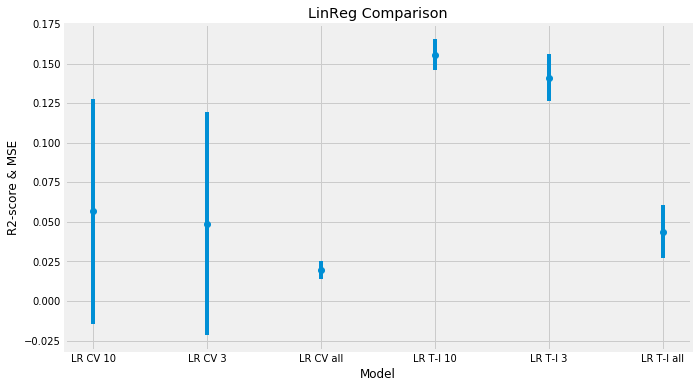

In [295]:
fig, ax = plt.subplots(figsize=(10,6))

x = ['LR CV all', 'LR CV 10', 'LR CV 3', 'LR T-I all', 'LR T-I 10', 'LR T-I 3'] # model name
y = [0.01980772845090491, 0.056714518090746825, 0.04898233274776317, 0.04393023170100274, 0.15566579301533467,
     0.1412092546981972] # r2-score
e = [0.005694508224194824, 0.07100166161906873, 0.07075671986192957, 0.01646133783802288, 0.009935040205793,
     0.015027535824352232]  # STD

ax.errorbar(x, y, yerr=e, fmt='o')
plt.xlabel('Model');
plt.ylabel('R2-score & MSE');
plt.title('LinReg Comparison');
plt.show()

**LassoRegressor**
Random_State(24, 45, 93)

Get the STD

In [287]:
# All features - cvec
print(np.std([0.19040608132068992,0.17404653973931827,0.19087349675047416]))

# Top 10 features - cvec
print(np.std([0.1770206960698385,0.15962691995511147,0.1764110503213686]))

# Top 3 features - cvec
print(np.std([0.1674465753925105,0.14525202070823995,0.17556026163488325]))

# All features - tvec
print(np.std([0.20023665642903288,0.18785746246084,0.1906026621960759]))

# Top 10 features - tvec
print(np.std([0.18211786284966514,0.1584402023128172,0.1827870531239365]))

# Top 3 features - tvec
print(np.std([0.1687431653626070,0.14744257772330882,0.17444502999551348]))

0.00782445994012733
0.008059653615519377
0.012810671029957805
0.005308215956516318
0.011322782189218176
0.011620665131012188


Get average R2-score

In [296]:
# All features - cvec
print(np.mean([0.19040608132068992,0.17404653973931827,0.19087349675047416]))

# Top 10 features - cvec
print(np.mean([0.1770206960698385,0.15962691995511147,0.1764110503213686]))

# Top 3 features - cvec
print(np.mean([0.1674465753925105,0.14525202070823995,0.17556026163488325]))

# All features - tvec
print(np.mean([0.20023665642903288,0.18785746246084,0.1906026621960759]))

# Top 10 features - tvec
print(np.mean([0.18211786284966514,0.1584402023128172,0.1827870531239365]))

# Top 3 features - tvec
print(np.mean([0.1687431653626070,0.14744257772330882,0.17444502999551348]))

0.18510870593682746
0.17101955544877287
0.16275295257854458
0.1928989270286496
0.17444837276213962
0.1635435910271431


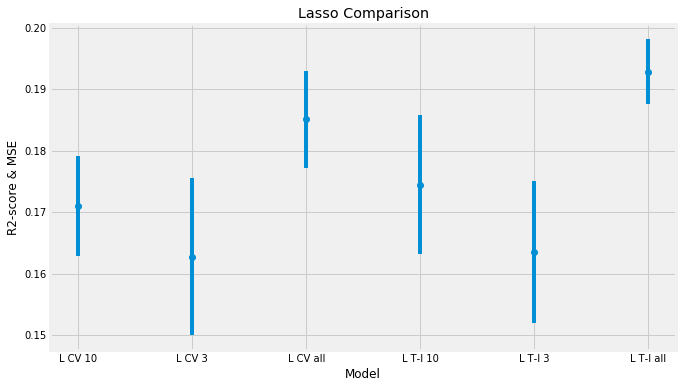

In [297]:
fig, ax = plt.subplots(figsize=(10,6))

x = ['L CV all', 'L CV 10', 'L CV 3', 'L T-I all', 'L T-I 10', 'L T-I 3'] # model name
y = [0.18510870593682746, 0.17101955544877287, 0.16275295257854458, 0.1928989270286496, 0.17444837276213962,
     0.1635435910271431] # r2-score
e = [0.00782445994012733, 0.008059653615519377, 0.012810671029957805, 0.005308215956516318, 0.011322782189218176,
     0.011620665131012188]  # STD

ax.errorbar(x, y, yerr=e, fmt='o')
plt.xlabel('Model');
plt.ylabel('R2-score & MSE');
plt.title('Lasso Comparison');
plt.show()

**RandomForestRegressor**
Random_State(24, 45, 93)

Get the STD

In [289]:
# All features - cvec
print(np.std([0.23981061254827155,0.20839979033017253,0.23969751428034336]))

# Top 10 features - cvec
print(np.std([0.2147670028572991,0.17549301752127533,0.22712790870077038]))

# Top 3 features - cvec
print(np.std([0.1638699609332285,0.134997303469086,0.16416023420397396]))

# All features - tvec
print(np.std([0.22945469325352852,0.22614904270409752,0.2300071173162116]))

# Top 10 features - tvec
print(np.std([0.19794165559197285,0.16863917510348325,0.21539716949022658]))

# Top 3 features - tvec
print(np.std([0.17616744455605482,0.14352678606807037,0.17411101965516518]))

0.01478061819522192
0.022013631899256494
0.013679632616335887
0.0017035008923659354
0.01929202589241116
0.014925879144076528


Get average R2-score

In [298]:
# All features - cvec
print(np.mean([0.23981061254827155,0.20839979033017253,0.23969751428034336]))

# Top 10 features - cvec
print(np.mean([0.2147670028572991,0.17549301752127533,0.22712790870077038]))

# Top 3 features - cvec
print(np.mean([0.1638699609332285,0.134997303469086,0.16416023420397396]))

# All features - tvec
print(np.mean([0.22945469325352852,0.22614904270409752,0.2300071173162116]))

# Top 10 features - tvec
print(np.mean([0.19794165559197285,0.16863917510348325,0.21539716949022658]))

# Top 3 features - tvec
print(np.mean([0.17616744455605482,0.14352678606807037,0.17411101965516518]))

0.22930263905292914
0.2057959763597816
0.15434249953542947
0.22853695109127922
0.1939926667285609
0.16460175009309677


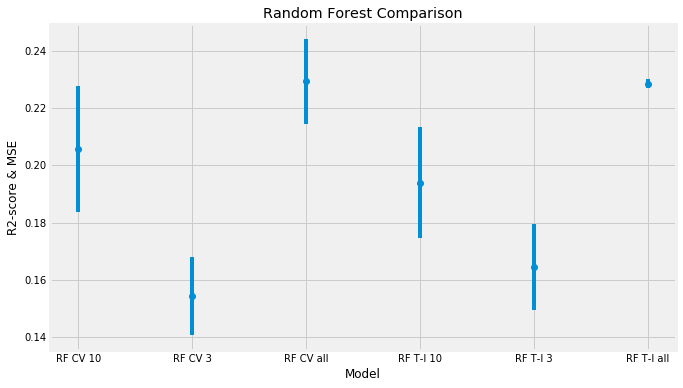

In [299]:
fig, ax = plt.subplots(figsize=(10,6))

x = ['RF CV all', 'RF CV 10', 'RF CV 3', 'RF T-I all', 'RF T-I 10', 'RF T-I 3'] # model name
y = [0.22930263905292914, 0.2057959763597816, 0.15434249953542947, 0.22853695109127922, 0.1939926667285609,
     0.16460175009309677] # r2-score
e = [0.01478061819522192, 0.022013631899256494, 0.013679632616335887, 0.0017035008923659354, 0.01929202589241116,
     0.014925879144076528]  # STD

ax.errorbar(x, y, yerr=e, fmt='o')
plt.xlabel('Model');
plt.ylabel('R2-score & MSE');
plt.title('Random Forest Comparison');
plt.show()

**AdaBoosterRegressor+GradientBoosterRegressor**
Random_State(24, 45, 93)

Get the STD

In [291]:
# Ada - cvec
print(np.std([0.1647279913503793,0.1260161744267283,0.14335867665868918]))

# Gradient - All features - cvec
print(np.std([0.2384226323540044,0.19561866237021341,0.2535206901866619]))

# Gradient - Top 10 features - cvec
print(np.std([0.17780645284450913,0.14824439498337494,0.18773960223737296]))

# Gradient - Top 3 features - cvec
print(np.std([0.15909022715580334,0.13456193157934704,0.1705488348277141]))

# Ada - tvec
print(np.std([0.14338493550827192,0.12579045980554426,0.1392586571648562]))

# Gradient - All features - tvec
print(np.std([0.2362633185213301,0.2211882713240544,0.22923030888254725]))

# Gradient - Top 10 features - tvec
print(np.std([0.1706690669450912,0.1580145238694437,0.20597373286852028]))

# Gradient - Top 3 features - tvec
print(np.std([0.15778723525858485,0.1292902572459732,0.1674764124876682]))

0.015832507920900254
0.024523856915139964
0.016774498230224536
0.015011085455874528
0.007512834117773193
0.006158955906027438
0.020294067617671097
0.016207475515845865


Get average R2-score

In [300]:
# Ada - cvec
print(np.mean([0.1647279913503793,0.1260161744267283,0.14335867665868918]))

# Gradient - All features - cvec
print(np.mean([0.2384226323540044,0.19561866237021341,0.2535206901866619]))

# Gradient - Top 10 features - cvec
print(np.mean([0.17780645284450913,0.14824439498337494,0.18773960223737296]))

# Gradient - Top 3 features - cvec
print(np.mean([0.15909022715580334,0.13456193157934704,0.1705488348277141]))

# Ada - tvec
print(np.mean([0.14338493550827192,0.12579045980554426,0.1392586571648562]))

# Gradient - All features - tvec
print(np.mean([0.2362633185213301,0.2211882713240544,0.22923030888254725]))

# Gradient - Top 10 features - tvec
print(np.mean([0.1706690669450912,0.1580145238694437,0.20597373286852028]))

# Gradient - Top 3 features - tvec
print(np.mean([0.15778723525858485,0.1292902572459732,0.1674764124876682]))

0.14470094747859893
0.22918732830362656
0.17126348335508568
0.15473366452095483
0.13614468415955747
0.2288939662426439
0.17821910789435172
0.15151796833074208


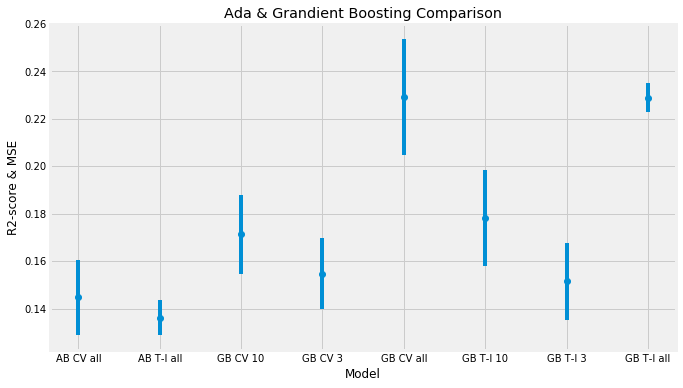

In [301]:
fig, ax = plt.subplots(figsize=(10,6))

x = ['AB CV all','GB CV all', 'GB CV 10', 'GB CV 3', 'AB T-I all', 'GB T-I all', 'GB T-I 10', 'GB T-I 3'] # model name
y = [0.14470094747859893, 0.22918732830362656, 0.17126348335508568, 0.15473366452095483, 0.13614468415955747,
     0.2288939662426439, 0.17821910789435172, 0.15151796833074208] # r2-score
e = [0.015832507920900254, 0.024523856915139964, 0.016774498230224536, 0.015011085455874528, 0.007512834117773193,
     0.006158955906027438, 0.020294067617671097, 0.016207475515845865]  # STD

ax.errorbar(x, y, yerr=e, fmt='o')
plt.xlabel('Model');
plt.ylabel('R2-score & MSE');
plt.title('Ada & Grandient Boosting Comparison');
plt.show()

**Best from each Model-type**
Random_State(24, 45, 93)

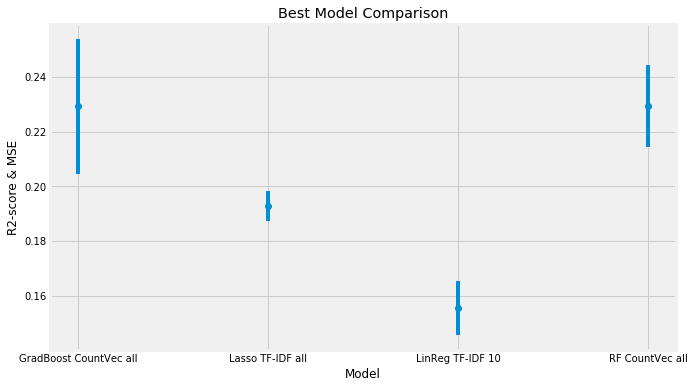

In [302]:
fig, ax = plt.subplots(figsize=(10,6))

x = ['LinReg TF-IDF 10', 'Lasso TF-IDF all', 'RF CountVec all', 'GradBoost CountVec all'] # model name
y = [0.15566579301533467, 0.1928989270286496, 0.22930263905292914, 0.22918732830362656] # r2-score
e = [0.009935040205793, 0.005308215956516318, 0.01478061819522192, 0.024523856915139964] # STD

plt.errorbar(x, y, yerr=e, fmt='o')
plt.xlabel('Model');
plt.ylabel('R2-score & MSE');
plt.title('Best Model Comparison');
plt.show()